#### Map of trend (slope) 1979-2022 of:
 - Annual max Tmax  (units C/decade)
 - Annual number of days of frozen precip (units days)
 
 https://en.wikipedia.org/wiki/List_of_counties_in_Oregon
casper_2020

In [1]:
import calendar
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
from datetime import timedelta, date
import mapclassify as mc
import geoplot as gplt
import contextily as cx
import os
from os.path import exists
from scipy import stats

from innovator_func import (
    add_shape_coord_from_data_array,
    create_shape_2d,
    rasterize,
    transform_from_latlon,
)

In [2]:
def rd_ts(dir_i, var_s): 
    '''
    read time series data from a csv file
    and return a DataFrame
    '''
    flnm = dir_i + var_s + "_1981-2021.csv"
    print('read in ', flnm)
 
    df = pd.read_csv(flnm)

    # convert date column to DateTime
    df['date'] = pd.to_datetime(df.date)

    # note: convert index to DatetimeIndex so I can use groupby year later on
    df.index =  pd.to_datetime(df.date)
    
    return df

def cal_trend_huc2_1d(arr_2d):
    '''
    arr_2d(year, n_shp) 
    calculate trend of 2D array
    '''
    
    n_shp = arr_2d.shape[1]
    trend_1d = np.zeros(n_shp)

    for nr in range(n_shp):
        arr_1d = arr_2d[:,nr]
        # first degree polynomial. linear regression 
        trend_1d[nr] = np.polyfit(range(len(arr_1d)), arr_1d,1)[0]
    return trend_1d

#### read csv time-series files

In [3]:
dir_data = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/'

df_tmax = rd_ts(dir_data, 'Tmax')
df_tmin = rd_ts(dir_data, 'Tmin')
df_prec = rd_ts(dir_data, 'PR')

year_s = df_tmax.year[0]
year_e = df_tmax.year[-1]

# get column name by df.columns
name_col = df_tmax.columns
print('columns are:', name_col)

read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/Tmax_1981-2021.csv
read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/Tmin_1981-2021.csv
read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/PR_1981-2021.csv
columns are: Index(['date', 'year', 'season', 'Clackamas', 'Columbia', 'Multmomah',
       'Washington', 'Yamhill'],
      dtype='object')


#### read shapefile and pick/merge 3 counties

In [4]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/counties.shp'
shp_gpd = gpd.read_file(flnm_shp)
 
# Clackamas 005 2;  Multnomah 051 25; Washington 067 33
id_s = ['005', '051', '067']
n_county = len(id_s)

## Merging Data: Appending DataFrames
gdf1 = shp_gpd[shp_gpd.COUNTY == id_s[0]]
gdf2 = shp_gpd[shp_gpd.COUNTY == id_s[1]]
gdf3 = shp_gpd[shp_gpd.COUNTY == id_s[2]]

new_gpd = pd.concat([gdf1, gdf2, gdf3])

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
new_gpd = new_gpd.to_crs('EPSG:4326')

new_gpd['lon_centroid'] = new_gpd.centroid.x
new_gpd['lat_centroid'] = new_gpd.centroid.y

new_gpd

/glade/scratch/mingge/ipykernel_77083/2910250391.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gpd['lon_centroid'] = new_gpd.centroid.x
/glade/scratch/mingge/ipykernel_77083/2910250391.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gpd['lat_centroid'] = new_gpd.centroid.y


,ID,STFID,COUNTY,TAPERSONS,TA1RACE,TAWHITE,TABLACK,TAAMERIND,TAASIAN,TAHAWPAC,...,TN4RACES,TN5RACES,TN6RACES,ALLAFAM,ALLAMIND,ALLASIAN,ALLNHPI,geometry,lon_centroid,lat_centroid
2,1,41005,005,338391,330061,308852,2233,2416,8292,569,...,38,18,0,3497,5256,10921,1348,"POLYGON ((-122.63724 45.46112, -122.63650 45.4...",-122.221525,45.188663
25,1,41051,051,660486,633622,522825,37434,6785,37638,2320,...,101,35,0,44755,14701,45012,4419,"POLYGON ((-122.85432 45.59182, -122.85670 45.5...",-122.415730,45.546896
33,1,41067,067,445342,431216,366007,5119,2913,29752,1325,...,37,6,1,7307,6183,35197,2876,"POLYGON ((-122.78711 45.54843, -122.78481 45.5...",-123.098537,45.560109


#### Trend of annual max Tmax map

Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington'], dtype='object')
trend [0.28495188 0.14275295 0.1650441 ]
    ID  STFID COUNTY  TAPERSONS  TA1RACE  TAWHITE  TABLACK  TAAMERIND  \
2    1  41005    005     338391   330061   308852     2233       2416   
25   1  41051    051     660486   633622   522825    37434       6785   
33   1  41067    067     445342   431216   366007     5119       2913   

    TAASIAN  TAHAWPAC  ...  TN5RACES  TN6RACES  ALLAFAM  ALLAMIND  ALLASIAN  \
2      8292       569  ...        18         0     3497      5256     10921   
25    37638      2320  ...        35         0    44755     14701     45012   
33    29752      1325  ...         6         1     7307      6183     35197   

    ALLNHPI                                           geometry  lon_centroid  \
2      1348  POLYGON ((-122.63724 45.46112, -122.63650 45.4...   -122.221525   
25     4419  POLYGON ((-122.85432 45.59182, -122.85670 45.5...   -122.415730   
33     2876  POLYGON ((-122.78711

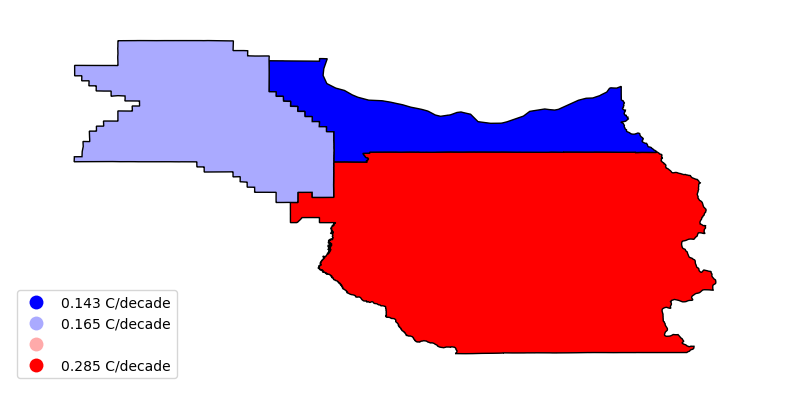

In [5]:
# Index(['date', 'year', 'season', 'Clackamas', 'Columbia', 'Multmomah','Washington', 'Yamhill']
# 0-based index for Clackamas, Multmomah and Washington are:
id_col = [3,5,6]
print(df_tmax.columns[3:7])

# get time-series of those locations
df_max = df_tmax[[name_col[id_col[0]], name_col[id_col[1]],name_col[id_col[2]]]].groupby(lambda x: x.year).max()
arr_2d = df_max.to_numpy() 

# treand in decade 
trend_1d = cal_trend_huc2_1d(arr_2d)*10
print('trend',trend_1d)

import mapclassify as mc
### create a common scheme for trend plots
arr_1d =np.linspace(0.1, 0.3, 11)
scheme = mc.Quantiles(arr_1d, k = 4)

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
new_gpd['Tmax'] = np.asarray(trend_1d)
print(new_gpd)

legend_labels=['0.143 C/decade','0.165 C/decade','', '0.285 C/decade']
gplt.choropleth(new_gpd, hue='Tmax', scheme = scheme, cmap='bwr', legend=True,legend_labels=legend_labels, ax=axs)
#axs.set_title(season_s[nn], fontsize=12)
plt.tight_layout();
plt.savefig('tmax_trend_map.pdf', bbox_inches='tight')

#### Trend of annual number of days of frozen precip map  

trend [-4.04355401 -2.97560976 -3.43205575]


/glade/scratch/mingge/ipykernel_77083/334422453.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Clackamas_Tmin'] = df_tmin['Clackamas'].values
/glade/scratch/mingge/ipykernel_77083/334422453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Multmomah_Tmin'] = df_tmin['Multmomah'].values
/glade/scratch/mingge/ipykernel_77083/334422453.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


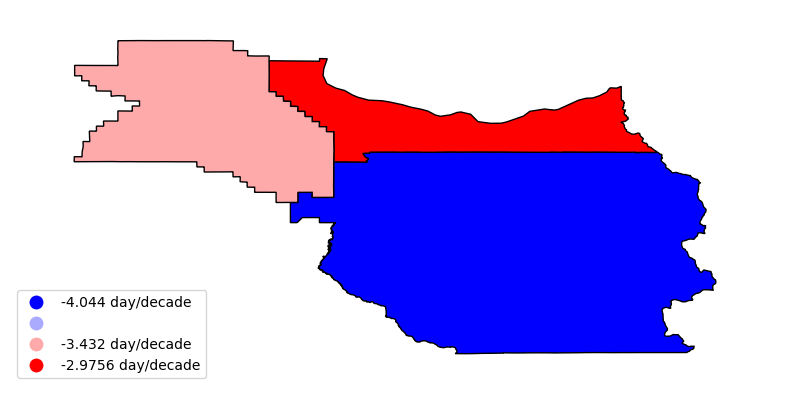

In [6]:
# get time-series of those locations
#df_min = df_tmin[[name_col[id_col[0]], name_col[id_col[1]],name_col[id_col[2]]]].groupby(lambda x: x.year).max()

df_new = df_prec[["year", "Clackamas", "Multmomah", "Washington"]]

# add Tmin info
df_new['Clackamas_Tmin'] = df_tmin['Clackamas'].values
df_new['Multmomah_Tmin'] = df_tmin['Multmomah'].values
df_new['Washington_Tmin'] = df_tmin['Washington'].values

# Re-create a new array of date, now including all years
years = list(range(1981,2022)) 

for nc in range(n_county):
    name_p = name_col[id_col[nc]]
    name_t = name_p + '_Tmin'
    # pick rows of frozen precip: Prec >0 and Tmin <0
    df_tmp = df_new.loc[(df_new[name_p] >0 ) & (df_new[name_t] < 0 )]  
    # count # of days of prozen prec
    dff = df_tmp[name_p].groupby(lambda x: x.year).agg('count') 
    # Reindex the count and fill empty values with zero (NaN by default)
    dff = dff.reindex(years, fill_value=0)
    #print(dff)
    arr_2d[:,nc] = dff.values
    
# treand in decade 
trend_1d = cal_trend_huc2_1d(arr_2d)*10
print('trend', trend_1d)

import mapclassify as mc
### create a common scheme for trend plots
arr_1d =np.linspace(-4.1, -2.8, 11)
scheme = mc.Quantiles(arr_1d, k = 4)

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
new_gpd['FrozenPrec'] = np.asarray(trend_1d)
#print(new_gpd)

legend_labels=['-4.044 day/decade','','-3.432 day/decade','-2.9756 day/decade']
gplt.choropleth(new_gpd, hue='FrozenPrec', scheme = scheme, cmap='bwr', legend=True,
                legend_labels=legend_labels,ax=axs)
#axs.set_title(season_s[nn], fontsize=12)
plt.tight_layout();
plt.savefig('precFrozon_trend_map.pdf', bbox_inches='tight')

In [7]:
scheme.bins 

array([-3.775, -3.45 , -3.125, -2.8  ])

In [8]:
scheme

Quantiles             

   Interval      Count
----------------------
[-4.10, -3.77] |     3
(-3.77, -3.45] |     3
(-3.45, -3.12] |     2
(-3.12, -2.80] |     3

#### Start

#### read and exame shapefile

/glade/scratch/mingge/ipykernel_77083/3967849840.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_77083/3967849840.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_77083/3967849840.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 416 entries, 0 to 415
Columns: 103 entries, pop to lat_centroid
dtypes: float64(98), geometry(1), int64(4)
memory usage: 334.9 KB


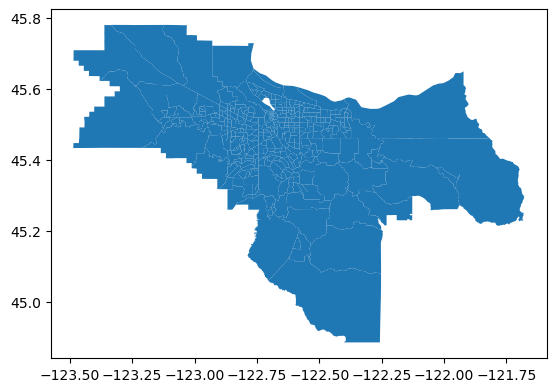

In [74]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

# n_shp = 416
n_shp = len(shp_gpd.centroid)

shp_gpd.plot()
# geopandas is built off pandas. It inherits most of the same functionality as a regular dataframe. 
shp_gpd.info()

#### concatenate prism data of zoomed region

In [75]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
dir_plot  = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/PLOT/'

year_s = 1981
year_e = 2021
#year_s = year_e - 1
n_year = year_e - year_s + 1

# creat a 2D numpy array [n_day, n_loc]
arr_2d = np.array([[0]*n_shp]*n_year, dtype=np.float32)

var_s = "PR"
var_s = "Tmax"
#var_s = "Tmin"

In [76]:
# 2 read zoomed dataset PRISM and add shapes
flnm_data = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/' + var_s + '_1981-2021_oregon_annual.nc' 

if os.path.exists(flnm_data):
    with xr.open_dataset(flnm_data ) as ds_data:
        data_3d = ds_data[var_s]
else:
    for year in range(year_s, year_e+1, 1):
    
        flnm_prism = dir_prism + var_s + '/PRISM_daily_ppt_'+ str(year) + '.nc'     

        with xr.open_dataset(flnm_prism ) as ds_prism:
            print('process:', flnm_prism)
            data_3d0 = ds_prism.isel(rlat=slice(88,122), rlon=slice(26, 82))[var_s].max(dim='time' )
        
            if year == year_s:
                data_3d = data_3d0.copy()
            else:
                # concatinate along new dimension name:'time' (it is added along axis=0)
                data_3d = xr.concat([data_3d, data_3d0], dim='time')
             
            data_3d.to_netcdf(flnm_data)
            print ('finished saving', flnm_data)
print(data_3d)

<xarray.DataArray 'Tmax' (time: 41, rlat: 34, rlon: 56)>
[78064 values with dtype=float32]
Coordinates:
    lat      (rlat, rlon) float32 ...
    lon      (rlat, rlon) float32 ...
  * rlat     (rlat) float32 46.25 46.21 46.17 46.12 ... 45.0 44.96 44.92 44.88
  * rlon     (rlon) float32 -123.9 -123.9 -123.8 -123.8 ... -121.7 -121.7 -121.6
Dimensions without coordinates: time


##### extract nearest point of each shapefile centroid

In [77]:
dtmax_1d  = np.zeros((n_shp))
slope_1d  = np.zeros((n_shp))
pvalue_1d = np.zeros(n_shp)

for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    arr_1d = data_3d.sel(rlon=lon_0, rlat=lat_0, method="nearest").values
    # linear regression 
    slope,intercept,r,p,se = stats.linregress(range(year_s, year_e+1), arr_1d*9/5+32) 
    
    dtmax_1d[nn]  = slope*(n_year-1)
    slope_1d[nn]  = slope
    pvalue_1d[nn] = p   
#pvalue_1d[pvalue_1d>0.05 ] =np.nan     
shp_gpd['tmax_trend'] = dtmax_1d 
shp_gpd['tmax_slope'] = slope_1d 
shp_gpd['tmax_p-value'] = pvalue_1d

In [84]:
pvalue_1d.min()

0.1943206190532745

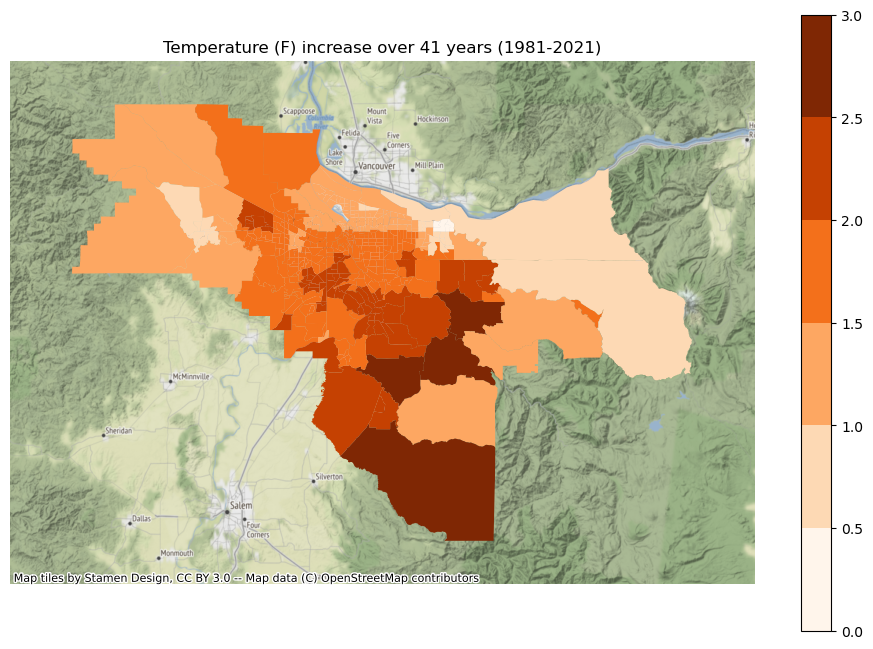

In [94]:
# plot temperature increase over 41 years from 1981-2021
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
ax.set_title('Temperature (F) increase over 41 years (1981-2021)')
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
shp_gpd.plot(ax=ax, column='tmax_trend', cmap = plt.cm.get_cmap('Oranges', 6), vmin=0, vmax=3, legend=True) #, scheme="quantiles");
plt.savefig(dir_plot + 'tmax_trend_oregon.pdf', bbox_inches='tight')

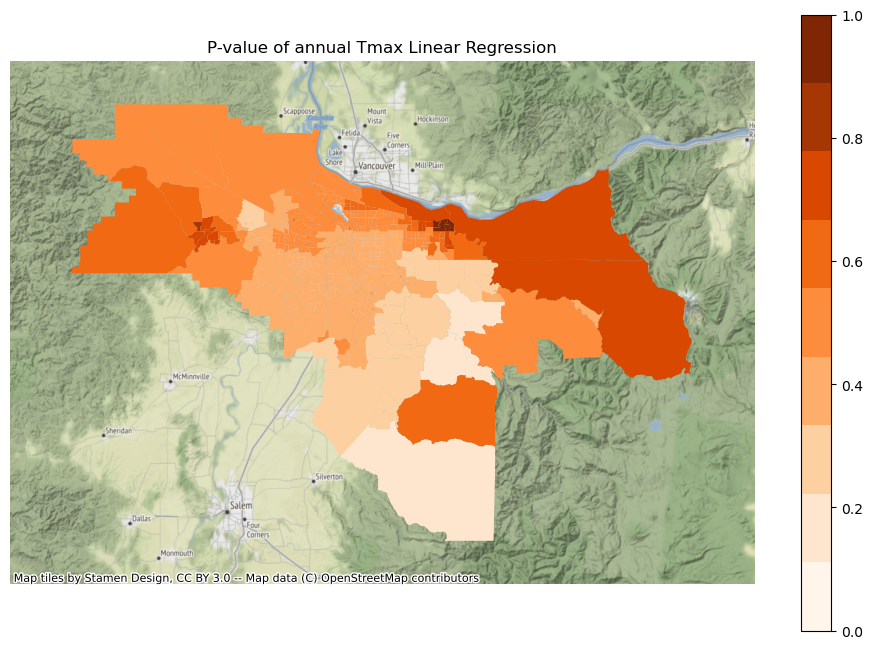

In [91]:
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
ax.set_title('P-value of annual Tmax Linear Regression')
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
shp_gpd.plot(ax=ax, column='tmax_p-value', cmap = plt.cm.get_cmap('Oranges', 9), vmin=0, vmax=1, legend=True) #, scheme="quantiles");
plt.savefig(dir_plot + 'tmax_p-value_oregon.pdf', bbox_inches='tight')

In [102]:
# 2 read zoomed dataset PRISM and add shapes
flnm_data = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/frozenprec_1981-2021_oregon_annual.nc' 

if os.path.exists(flnm_data):
    with xr.open_dataset(flnm_data ) as ds_data:
        data_3d = ds_data.__xarray_dataarray_variable__
else:
    for year in range(year_s, year_e+1, 1):
        flnm_prec = dir_prism + 'PR/PRISM_daily_ppt_'+ str(year) + '.nc'
        flnm_tmin = dir_prism + 'Tmin/PRISM_daily_tmin_'+ str(year) + '.nc'

        with xr.open_dataset(flnm_prec ) as ds_prec:
            with xr.open_dataset(flnm_tmin) as ds_tmin:
                print('process:', flnm_prec)
                data_prec = ds_prec.isel(rlat=slice(88,122), rlon=slice(26, 82))['PR'] #.max(dim='time')
                data_tmin = ds_tmin.isel(rlat=slice(88,122), rlon=slice(26, 82))['Tmin']
                data_new = xr.where((data_tmin<0) & (data_prec>0), data_prec, 0)
                # note DataArray.where to use for locations in this object where cond is False.
                data_new = data_new.where(data_new==0, 1)
                
                count_2d = data_new.sum(dim='time')
                
                if year == year_s:
                    data_3d = count_2d.copy()
                else:
                    # concatiname along new dimension name:'time' it is added along axis=0
                    data_3d = xr.concat([data_3d, count_2d], dim='time')
             
                data_3d.to_netcdf(flnm_data)
                print ('finished saving', flnm_data)            

In [103]:
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    arr_1d = data_3d.sel(rlon=lon_0, rlat=lat_0, method="nearest").values
     
    slope, intercept, r, p, se = stats.linregress(range(year_s, year_e+1), arr_1d) 
    dtmax_1d[nn]  = slope*(n_year-1)
    slope_1d[nn]  = slope
    pvalue_1d[nn] = p 

# replace value with nan    
pvalue_1d[pvalue_1d>0.05 ] =np.nan     
shp_gpd['frozenPrec_trend'] = dtmax_1d  
shp_gpd['frozenPrec_slope'] = slope_1d 
shp_gpd['frozenPrec_p-value'] = pvalue_1d  

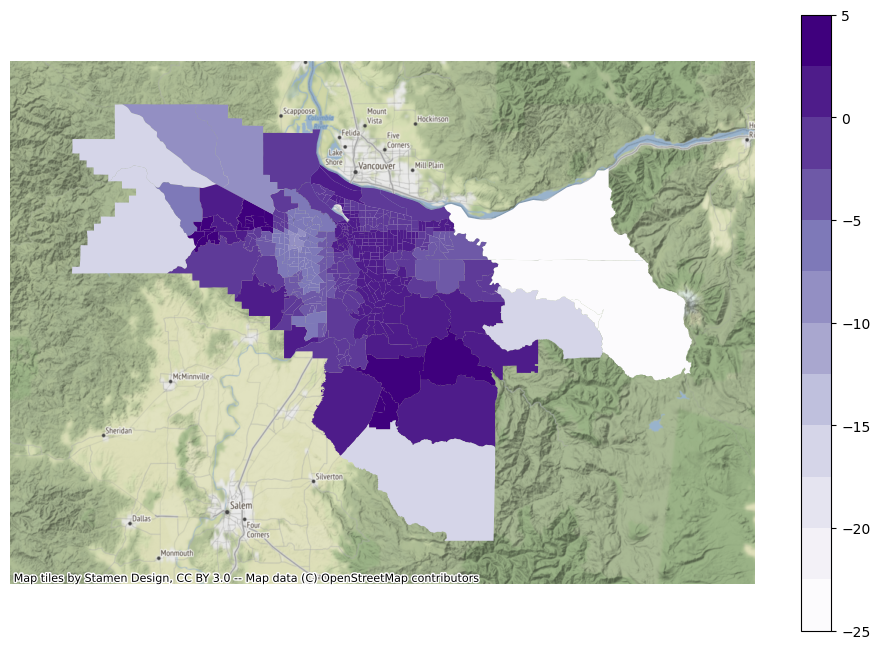

In [106]:
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
#ax.set_title('annual number of frezon precipitation days increase over 41 years (1981-2021)')
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
 
shp_gpd.plot(ax=ax, column='frozenPrec_trend', cmap = plt.cm.get_cmap('Purples', 12), legend=True, vmax = 5, vmin=-25)  
plt.savefig(dir_plot + 'frozenPrec_trend_oregon.pdf', bbox_inches='tight')

/glade/campaign/mmm/c3we/mingge/INNOVATOR/PLOT/ frozenPrec_p-value_frozenPrec_oregon.pdf


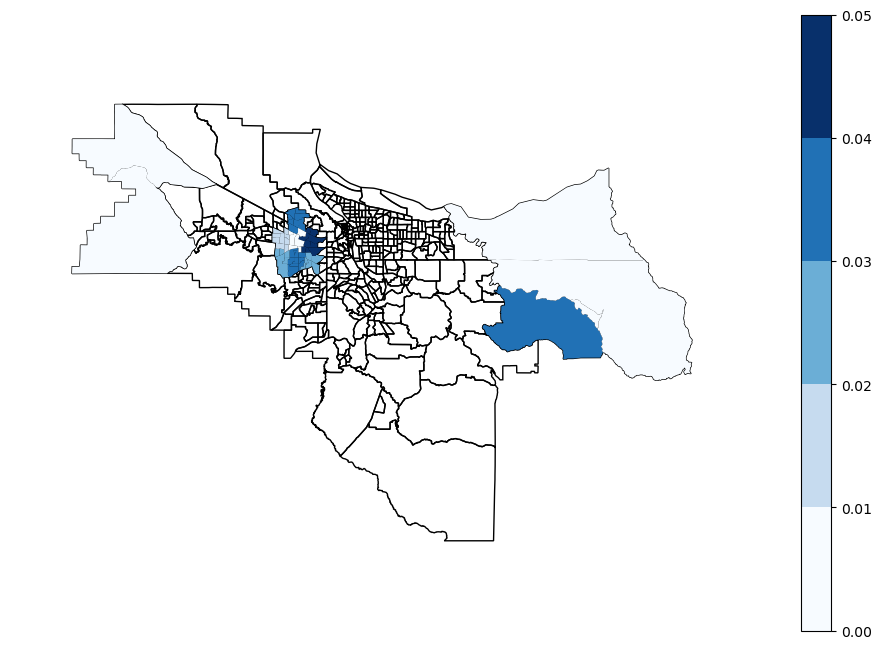

In [110]:
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
#cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
#ax.set_title('P-value of annual number of frozen precipitatin day Linear Regression')
shp_gpd.plot(ax=ax, column='frozenPrec_p-value', cmap = plt.cm.get_cmap('Blues', 5), vmin=0, vmax=0.05,  legend=True) #, scheme="quantiles");
plt.savefig(dir_plot + 'frozenPrec_p-value_frozenPrec_oregon.pdf', bbox_inches='tight')
print(dir_plot, 'frozenPrec_p-value_frozenPrec_oregon.pdf')

#### save to shapefile

In [21]:
dir_data = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/'
shp_gpd.to_file(dir_data + "tmax_frozenPrec_trend.shp")
shp_gpd

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/glade/scratch/mingge/ipykernel_153914/1359939526.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gpd.to_file(dir_data + "tmax_frozenPrec_trend.shp")


,pop,GEOID,over_65,ls_hs,eng_ltvw,occ_ag,occ_health,lw_1prnt,under_5,unemployed,...,pca7_z,geometry,lon_centroid,lat_centroid,tmax_trend,tmax_slope,tmax_p-value,frozenPrec_trend,frozenPrec_slope,frozenPrec_p-value
0,4580.0,4.100502e+10,0.105895,0.061873,0.006332,0.000000,0.096909,0.197356,0.040393,0.003861,...,0.485832,"POLYGON ((-122.86810 45.28733, -122.86801 45.2...",-122.833762,45.296255,1.922375,0.048059,0.375554,0.090592,0.002265,0.975344
1,6154.0,4.100502e+10,0.202957,0.052027,0.019662,0.000000,0.100955,0.210944,0.076373,0.025821,...,0.222250,"POLYGON ((-122.59746 45.36235, -122.59720 45.3...",-122.552172,45.350907,2.094097,0.052352,0.316571,2.020906,0.050523,0.423444
2,5725.0,4.100502e+10,0.126463,0.046963,0.012402,0.000000,0.091450,0.192771,0.084716,0.028991,...,-0.048972,"POLYGON ((-122.62776 45.31916, -122.62775 45.3...",-122.614662,45.321178,2.051362,0.051284,0.335045,2.181185,0.054530,0.382360
3,7024.0,4.100502e+10,0.093679,0.009924,0.043423,0.016074,0.108291,0.299127,0.104072,0.014238,...,0.054544,"POLYGON ((-122.84654 45.33286, -122.84652 45.3...",-122.803940,45.324272,1.938656,0.048466,0.375343,-5.331010,-0.133275,0.066807
4,4351.0,4.100502e+10,0.103884,0.211171,0.155596,0.064876,0.040547,0.347895,0.028040,0.021998,...,0.717385,"POLYGON ((-122.69218 45.26228, -122.69168 45.2...",-122.682149,45.259319,1.936169,0.048404,0.361357,-0.466899,-0.011672,0.853939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,3966.0,4.105101e+10,0.201715,0.039414,0.071609,0.003373,0.020723,0.067893,0.051942,0.040972,...,-0.458854,"POLYGON ((-122.44833 45.48124, -122.44831 45.4...",-122.436580,45.483893,0.898183,0.022455,0.655990,-3.372822,-0.084321,0.270415
412,4534.0,4.105100e+10,0.039259,0.026849,0.021173,0.000000,0.040447,0.521739,0.047199,0.023230,...,0.520978,"POLYGON ((-122.67923 45.54110, -122.67899 45.5...",-122.667092,45.544027,1.340076,0.033502,0.518397,1.024390,0.025610,0.656177
413,3057.0,4.106703e+10,0.082107,0.001524,0.007197,0.000000,0.076874,0.074789,0.035656,0.010913,...,0.563583,"POLYGON ((-122.79556 45.35344, -122.79549 45.3...",-122.787011,45.359216,1.986375,0.049659,0.369581,-3.665505,-0.091638,0.177515
414,2213.0,4.106703e+10,0.141437,0.069186,0.060099,0.000000,0.112664,0.168618,0.042476,0.005443,...,0.070403,"POLYGON ((-122.77484 45.37207, -122.77483 45.3...",-122.758062,45.372782,2.058771,0.051469,0.354101,-2.836237,-0.070906,0.281114
